# Let's try with downloaded Llama models

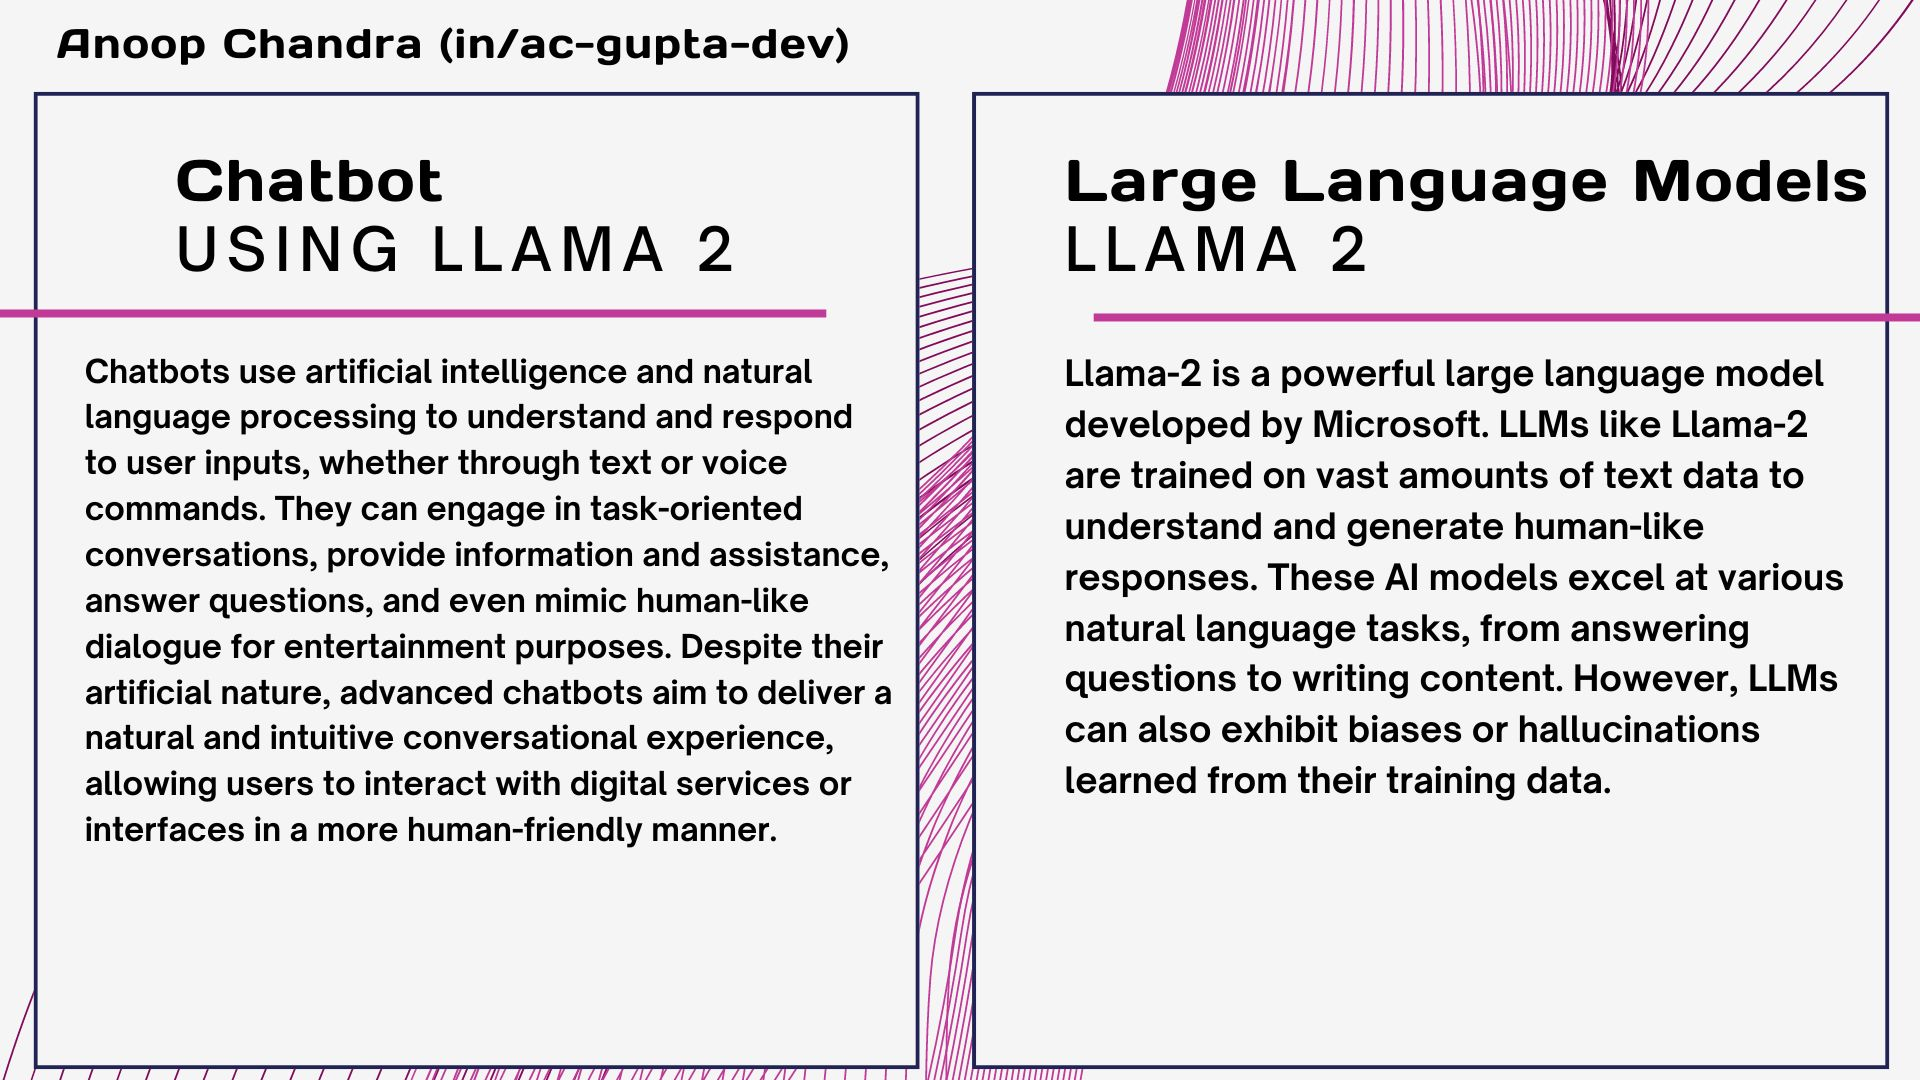

In [1]:
 from IPython.display import Image
 Image('Project.jpg')

In [1]:
from langchain import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Pinecone
import pinecone



c:\Users\anoop\anaconda3\envs\mchatbot\lib\site-packages\pinecone\index.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.document_loaders import PyPDFLoader, DirectoryLoader


In [3]:
from dotenv import load_dotenv
import os
load_dotenv()
PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY')
PINECONE_API_ENV = os.environ.get('PINECONE_API_ENV')

In [4]:
#Extract data from the PDF
def load_pdf(data):
    loader = DirectoryLoader(data,
                    glob="*.pdf",
                    loader_cls=PyPDFLoader)
    
    documents = loader.load()

    return documents

In [5]:
extracted_data = load_pdf("../data/")


In [6]:
#Create text chunks
def text_split(extracted_data):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 20)
    text_chunks = text_splitter.split_documents(extracted_data)

    return text_chunks


In [7]:
text_chunks = text_split(extracted_data)
print("length of my chunk:", len(text_chunks))


length of my chunk: 156


In [8]:
#download embedding model
def download_hugging_face_embeddings():
    embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=GOOGLE_API_KEY)

    return embeddings


In [9]:
embeddings = download_hugging_face_embeddings()


In [10]:
embeddings

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={})

In [11]:
query_result = embeddings.embed_query("Anoop Chandra")
print("Length", len(query_result))

Length 384


In [12]:
# query_result

In [13]:
#Initializing the Pinecone
pinecone.init(api_key=PINECONE_API_KEY,
              environment=PINECONE_API_ENV)

index_name="statistics-chatbot"
docsearch=Pinecone.from_existing_index(index_name, embeddings)


# ----------------if you already stored the data then no need to run this one ------------------
# Creating Embeddings for Each of The Text Chunks & storing

# docsearch=Pinecone.from_texts([t.page_content for t in text_chunks], embeddings, index_name=index_name)

In [ ]:
# If we already have an index we can load it like this

query = "What is data type of Temperature?"

docs=docsearch.similarity_search(query, k=3)

print("Result", docs)

Result [Document(page_content='Page 1 \n \nSH                                                       Statistics for Data Science  \n \n \nStatistics For Data Science \n \nWhat is Data? \n According to the Oxford “Data is distinct pieces of information, usually \nformatted in a special way”. \nData is measured, collected and reported, and analysed, whereupon it is often \nvisualized using graphs, images or other analysis tools. Raw data may be a collection of \nnumbers or characters before it’s been cleaned and corrected by researchers.', metadata={}), Document(page_content='Page 4 \n \nSH                                                       Statistics for Data Science  \n \nTypes of Data: \nGenerally, data can be classified into two parts: \n \n1. Categorical Data:  \nCategorical data refers to a data type that can be stored and identified based on \nthe names or labels given to them. A process called matching is done, to draw out the \nsimilarities or relations between the data and th

In [15]:
prompt_template="""
Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Question: {question}

Only return the helpful answer below and nothing else.
Helpful answer:
"""


In [16]:
PROMPT=PromptTemplate(template=prompt_template, input_variables=["context", "question"])
chain_type_kwargs={"prompt": PROMPT}

In [18]:
from langchain.llms import CTransformers


#### this is two bit model (2.9gb) If you have GPU or a good setup then you can go with better model

In [ ]:
llm=CTransformers(model="../model/llama-2-7b-chat.ggmlv3.q2_K.bin",
                  model_type="llama",
                  config={'max_new_tokens':512,
                          'temperature':0.8})

In [ ]:
qa=RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=docsearch.as_retriever(search_kwargs={'k': 2}),
    return_source_documents=True, 
    chain_type_kwargs=chain_type_kwargs)


In [ ]:
user_input=input(f"Input Prompt:")
result=qa({"query": user_input})
print("Response : ", result["result"])

### for 4 bit model (bigger than previous one)

In [20]:
llm2=CTransformers(model="../model/llama-2-7b-chat.ggmlv3.q4_0.bin",
                  model_type="llama",
                  config={'max_new_tokens':512,
                          'temperature':0.8})

In [21]:
qa=RetrievalQA.from_chain_type(
    llm=llm2, 
    chain_type="stuff", 
    retriever=docsearch.as_retriever(search_kwargs={'k': 2}),
    return_source_documents=True, 
    chain_type_kwargs=chain_type_kwargs)


In [22]:
   
result=qa({"query": "What is statistics ?"})
print("Response : ", result["result"])

Response :  Statistics is the branch of mathematics that deals with the study of collecting, analyzing, interpreting, presenting, and organizing data in a particular manner.
